# Localized Spectral Analysis on the Sphere

In Fourier analysis, a localised spectral estimate can be understood as the spectrum of a globally defined function that is multiplied with a window. In Fourier domain, this multiplication becomes a convolution, i.e. a window coefficient can only couple coefficients that fulfill: 

$$ \mathbf{k}_{loc} = \mathbf{k}_{glob} + \mathbf{k}_{win} $$

Windowing on the sphere leads to similar effects:
Multiplication with a window function on the sphere leads to coupling of the spherical harmonics coefficients of the globally defined function. Instead of a convolution, coupling is given by slightly more complex coupling matrix that takes into account a) the 2d nature of the problem (the power per l spectrum corresponds roughly to power per |k| in the Fourier case. I.e. coupling corresponds to coupling of coefficients on equal magnitude ***circles*** in Fourier domain) and b) the spherical symmetries (even functions don't couple with uneven).

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

## generate a random model using the class interface

we first generate a random model, using the class interface to shtools which simplifies coefficient generation and provides access to many convenience functions. We generate a scale-free random model, i.e. a model whose band power is flat beyond the scale length. The particular property of such a model is that it's variance doesn't change when zooming into a certain region

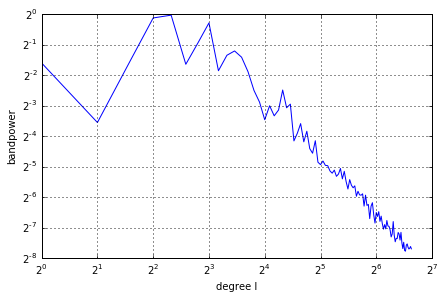

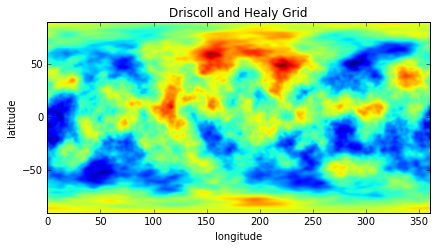

In [81]:
from pyshtools.shclasses import SHCoeffs, SHWindow, SHGrid

nl = 100  # l=[0, 199]
lmax = nl - 1
a = 4  # scale length
ls = np.arange(nl, dtype=np.float)
power = 1. / (1. + (ls / a) ** 2) ** 1.5

coeffs_global = SHCoeffs.from_random(power)
coeffs_global.plot_powerperband()
power_global = coeffs_global.get_powerperdegree()

grid_global = coeffs_global.expand('DH2')
grid_global.plot_rawdata()

## generate a box window functions

We now try to predict the global model spectrum based on a few local observations.

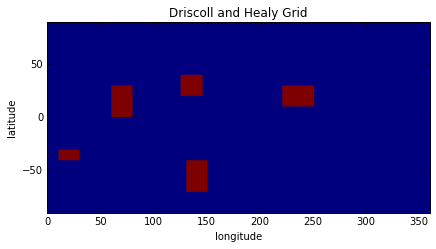

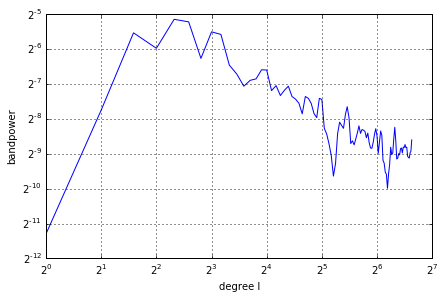

In [82]:
latgrid, longrid = np.meshgrid(grid_global.get_lats(), grid_global.get_lons(), indexing='ij')
window = (-40 < latgrid) & (latgrid < -30) & (10 < longrid) & (longrid < 30)
window += (0 < latgrid) & (latgrid < 30) & (60 < longrid) & (longrid < 80)
window += (-70 < latgrid) & (latgrid < -40) & (130 < longrid) & (longrid < 150)
window += (20 < latgrid) & (latgrid < 40) & (125 < longrid) & (longrid < 145)
window += (10 < latgrid) & (latgrid < 30) & (220 < longrid) & (longrid < 250)

grid_window = SHGrid.from_array(window.astype(np.float64)[::-1])  # DH grid starts at north-pole

grid_window.plot_rawdata()

coeffs_window = grid_window.expand()
coeffs_window.plot_powerperband()
power_window = coeffs_window.get_powerperdegree()
norm_window = power_window.sum()

## multiply the random model with the window

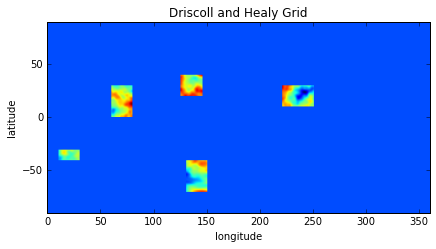

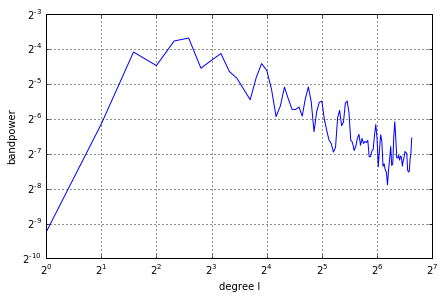

In [83]:
grid_local = SHGrid.from_array(grid_global.data * grid_window.data)
grid_local.plot_rawdata()

coeffs_local = grid_local.expand()
coeffs_local.plot_powerperband()
power_local = coeffs_local.get_powerperdegree()

## compute the coupling matrix

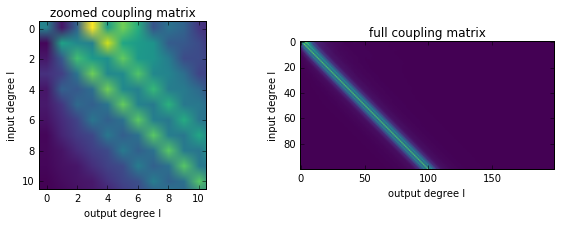

In [84]:
# compute the coupling matrix
from pyshtools.localizedspectralanalysis import SHMTCouplingMatrix
tapers = np.sqrt(power_window).reshape(nl, 1)
coupling_matrix = SHMTCouplingMatrix(lmax, tapers)

# plot the coupling matrix
fig, (col1, col2) = plt.subplots(1, 2, figsize=(10, 3))
col1.imshow(coupling_matrix, cmap='viridis')
col1.set(xlabel='output degree l', ylabel='input degree l', xlim=(-0.5, 10.5), ylim=(10.5, -0.5),
         title='zoomed coupling matrix');
col2.imshow(coupling_matrix, cmap='viridis')
col2.set(xlabel='output degree l', ylabel='input degree l', title='full coupling matrix');

## predict the biased spectrum

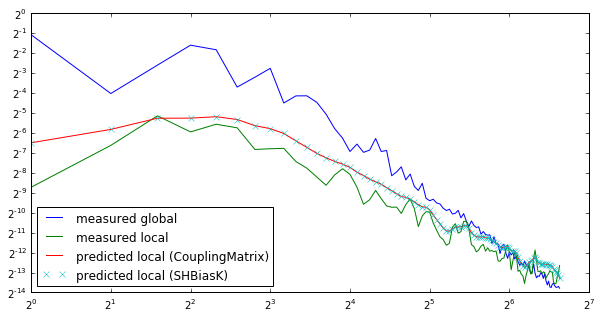

In [85]:
# compute the biased spectrum using two different functions
from pyshtools.localizedspectralanalysis import SHBiasK
power_local2 = np.dot(power, coupling_matrix)
power_local3 = SHBiasK(tapers, power)

# plot the observed and predicted spectra
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(ls, power_global, label='measured global')
ax.plot(ls, power_local, label='measured local')
ax.plot(ls, power_local2[:nl], label='predicted local (CouplingMatrix)')
ax.plot(ls, power_local3[:nl], 'x', label='predicted local (SHBiasK)')
ax.legend(loc=3)
ax.set_xscale('log', basex=2)
ax.set_yscale('log', basey=2)